# BBC-embeddings dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval.random import RandomEvaluator
from opendataval.dataval.margcontrib import LeaveOneOut, DataShapley, BetaShapley
from opendataval.dataval.influence import InfluenceFunctionEval
from opendataval.dataval.dvrl import DVRL
from opendataval.dataval.knnshap import KNNShapley
from opendataval.dataval.margcontrib.banzhaf import DataBanzhaf
from opendataval.dataval.ame import AME
from opendataval.dataval.oob import DataOob

from opendataval.experiment import ExperimentMediator

## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: bbc-embeddings
- Model: transformer's pretrained DistilBertModel + LogisticRegression
- Metric: Classification accuracy

In [2]:
dataset_name = "bbc-embeddings" 
train_count, valid_count, test_count = 1000, 100, 500
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch
metric_name = "accuracy"
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}
device = torch.device('cuda')

# feature extraction is performed when the following code is executed. (cpu takes 10-ish mins)
exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    device=device,
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='accuracy': perf=0.9520000219345093


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley ## slow
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley ## slow
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000) # Data-OOB
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000796


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.80it/s]


Elapsed time LeaveOneOut(): 0:00:38.798532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 35.76it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:27.966938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 154.78it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:13.031303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 11103.48it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.131516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.38it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:21.131544


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.93it/s]


Elapsed time AME(num_models=1000): 0:01:23.572513


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.29it/s]

Elapsed time DataOob(num_models=1000): 0:00:41.184104
CPU times: user 3min 39s, sys: 3.26 s, total: 3min 42s
Wall time: 3min 45s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/bbc-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.181984
DVRL(rl_epochs=2000),0.361290
DataBanzhaf(num_models=1000),0.196457
DataOob(num_models=1000),0.849558
InfluenceFunctionEval(num_models=1000),0.198083
KNNShapley(k_neighbors=100),0.579268
LeaveOneOut(),0.178723
RandomEvaluator(),0.163880


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

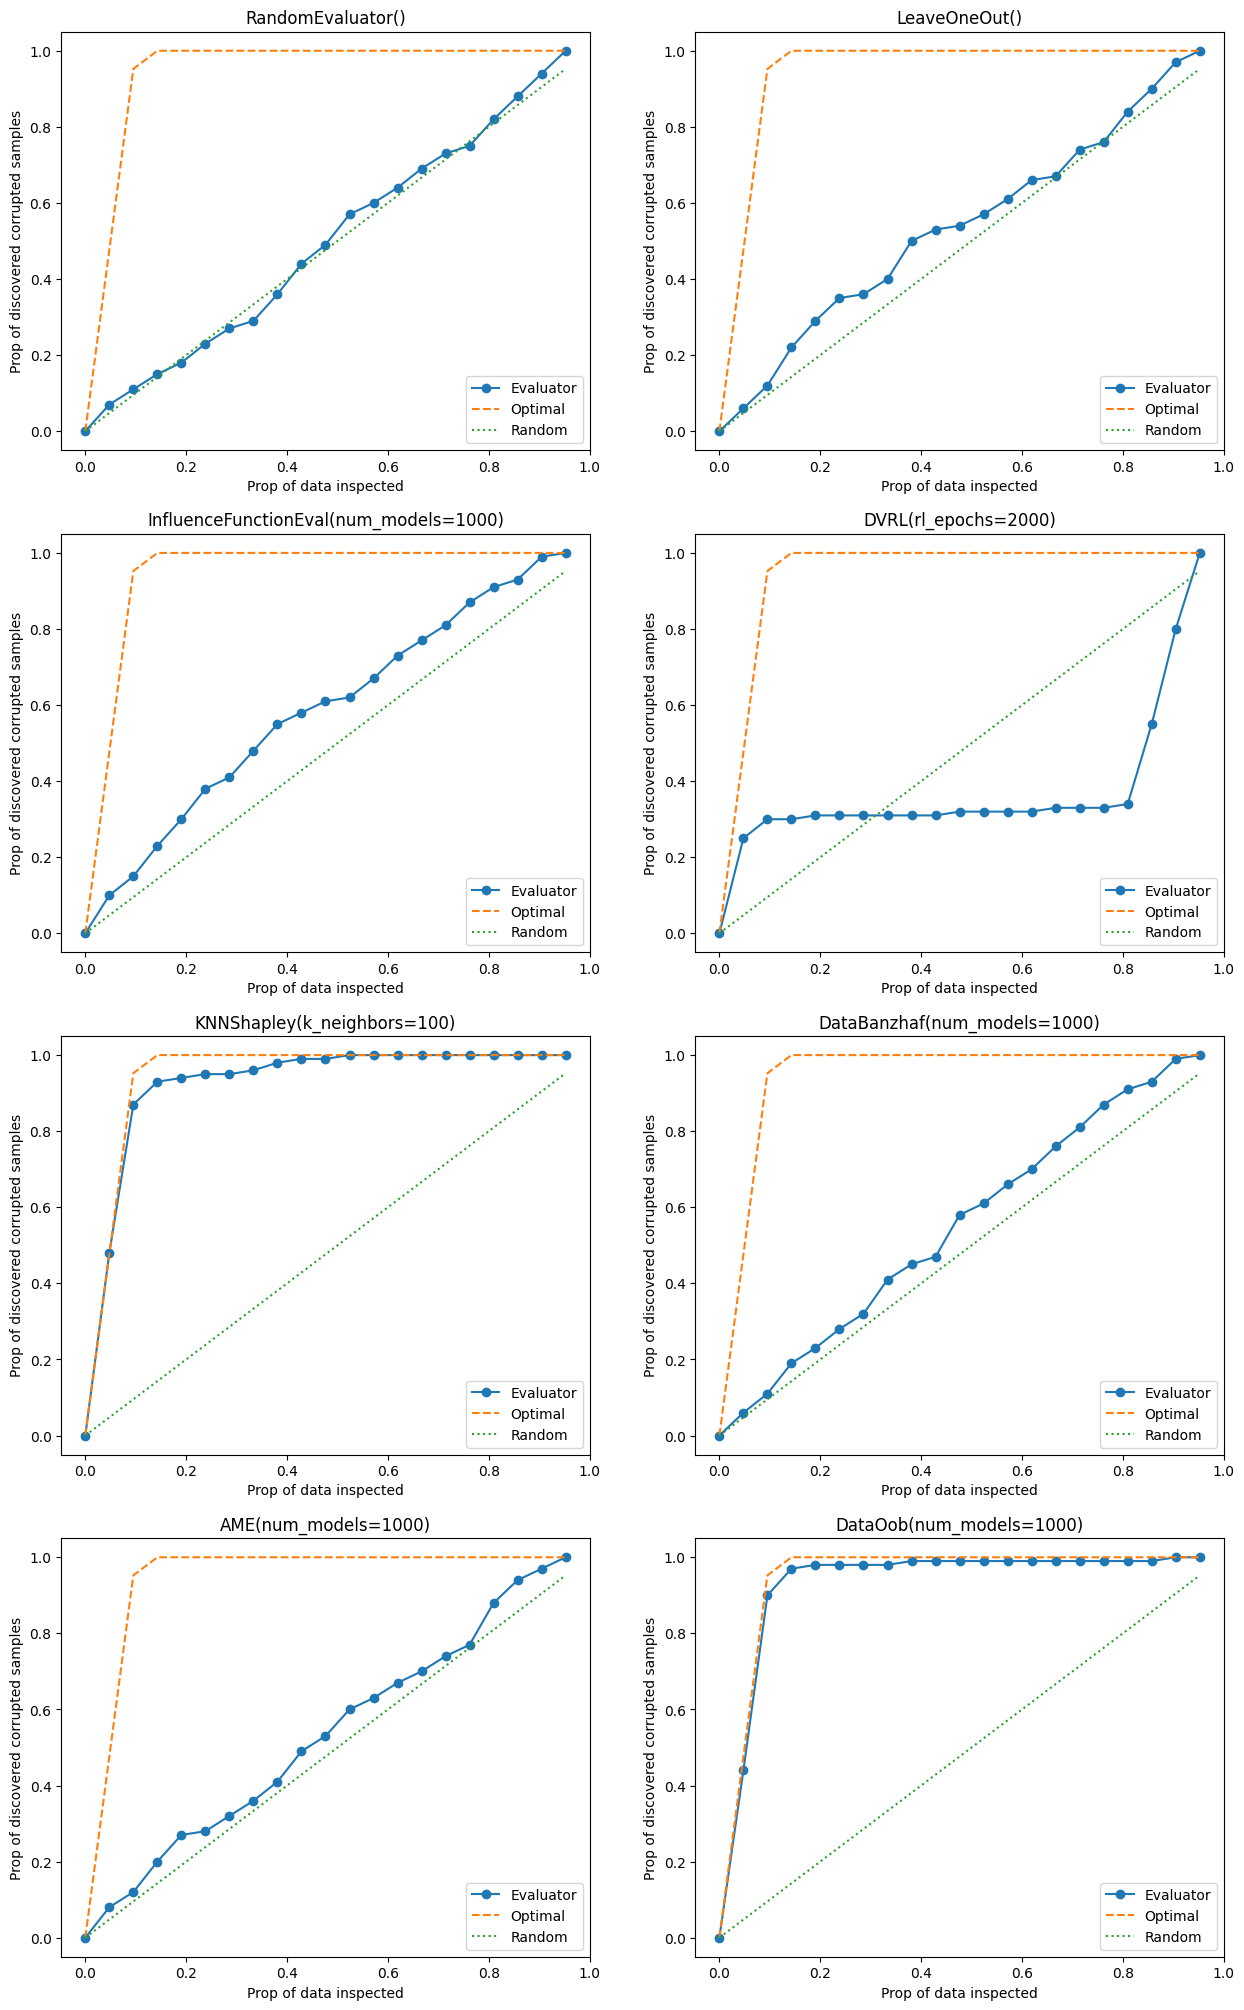

In [7]:
fig = plt.figure(figsize=(15, 25))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

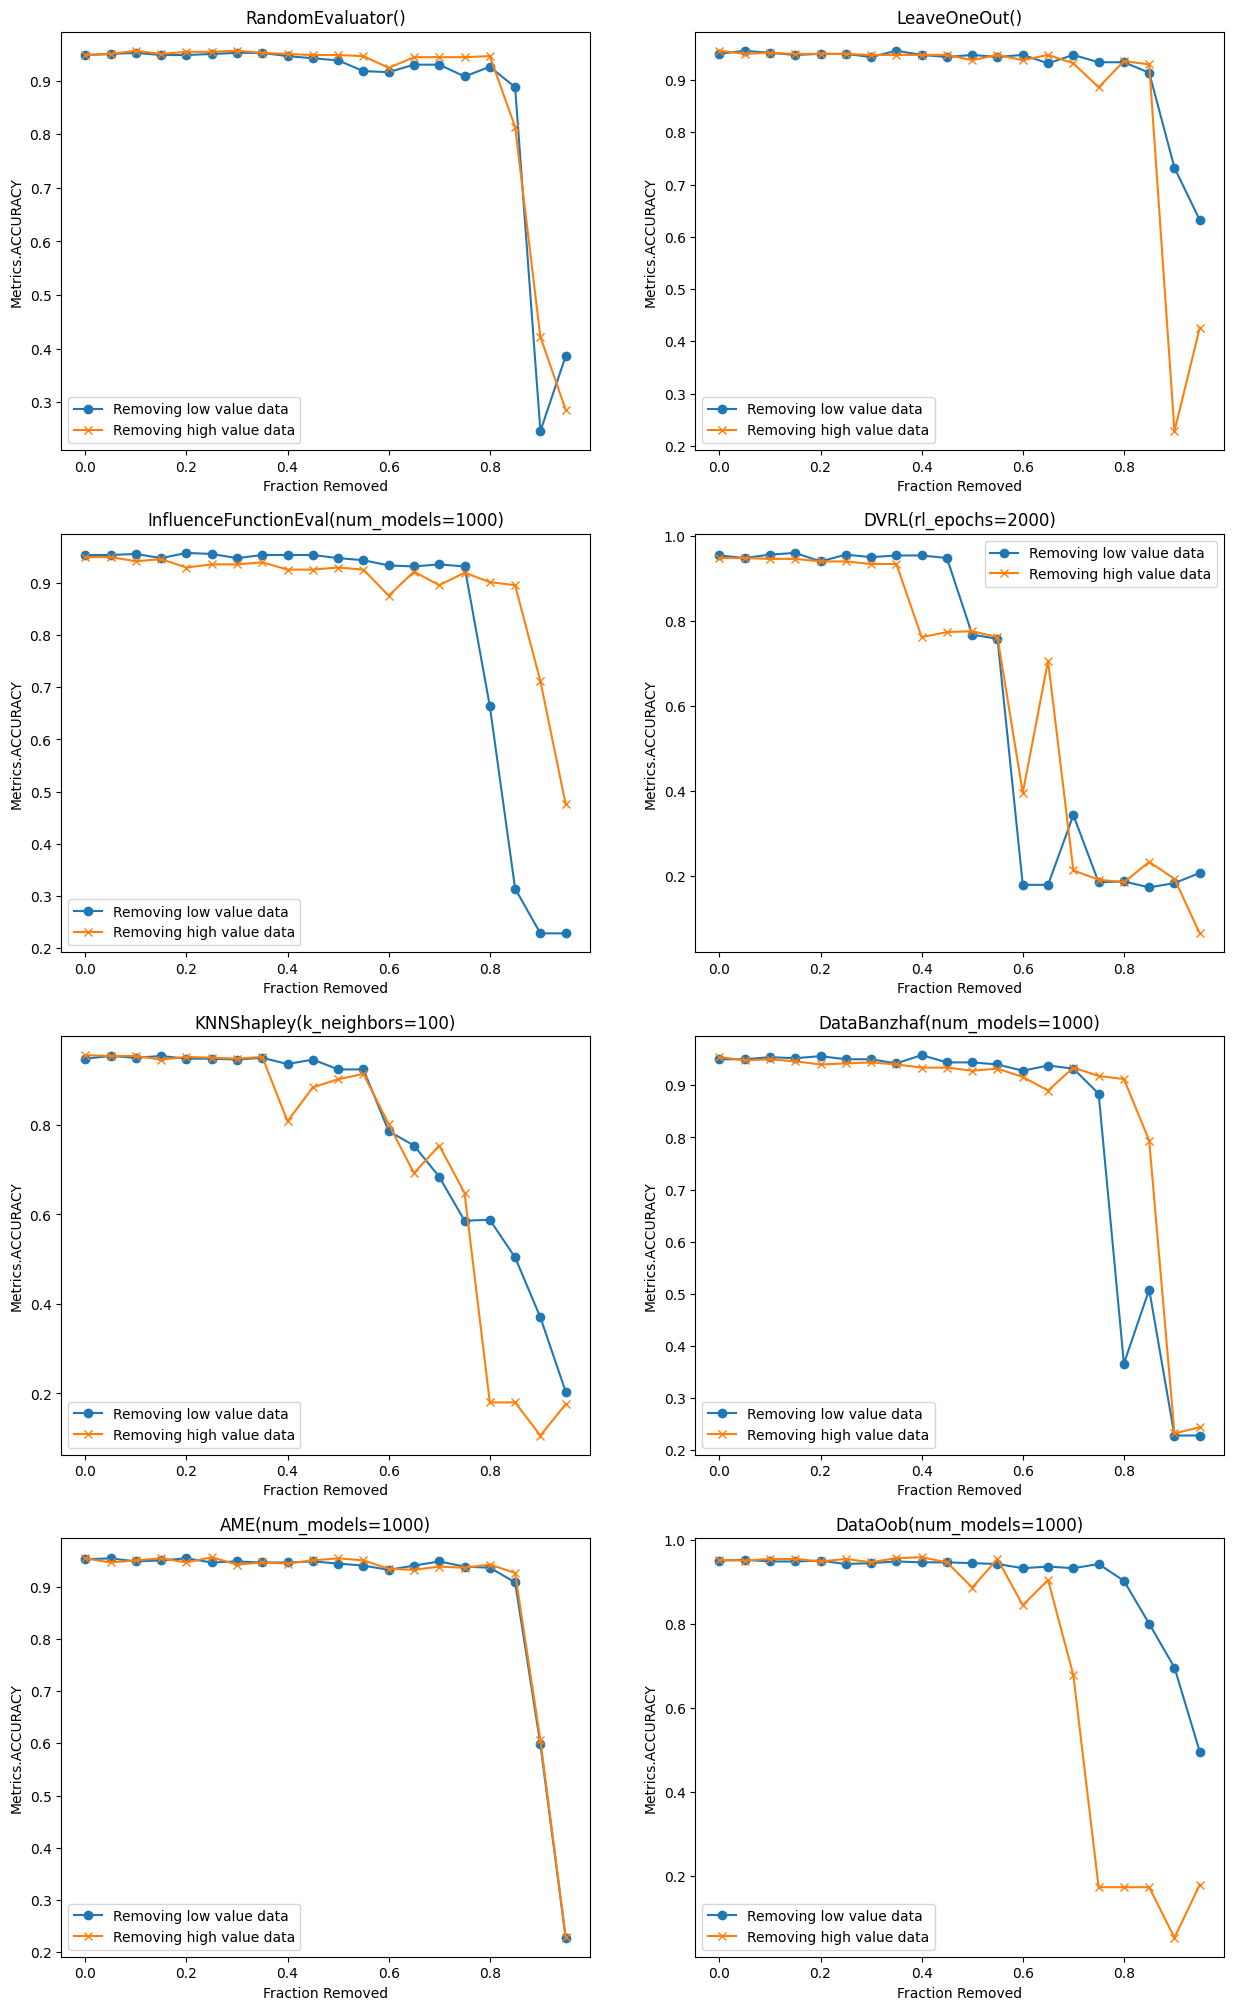

In [8]:
fig = plt.figure(figsize=(15, 25))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.948,0.948,0.0
RandomEvaluator(),0.95,0.95,0.05
RandomEvaluator(),0.952,0.956,0.1
RandomEvaluator(),0.948,0.95,0.15
RandomEvaluator(),0.948,0.954,0.2
...,...,...,...
DataOob(num_models=1000),0.942,0.174,0.75
DataOob(num_models=1000),0.902,0.174,0.8
DataOob(num_models=1000),0.8,0.174,0.85
DataOob(num_models=1000),0.696,0.054,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),1068,0.839489
RandomEvaluator(),21,0.656369
RandomEvaluator(),259,0.870193
RandomEvaluator(),173,0.691388
RandomEvaluator(),741,0.107865
...,...,...
DataOob(num_models=1000),754,1.0
DataOob(num_models=1000),458,1.0
DataOob(num_models=1000),1561,0.0
DataOob(num_models=1000),2113,0.145161
